In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
    
print(tf.__version__)
print(sys.version_info)

for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [ ]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(len(gpus))
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(logical_gpus))

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)


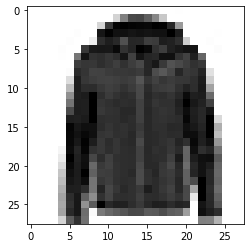

In [3]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap='binary')
    plt.show()
    
show_single_image(x_train[0])

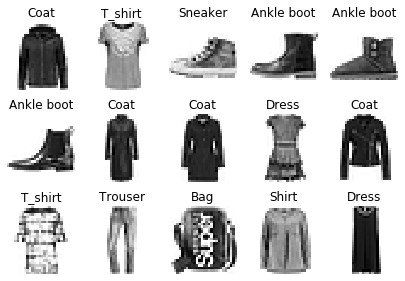

In [4]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(x_data[index], cmap='binary', interpolation = 'nearest')
            
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()

class_names = ['T_shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

Relu: 
$$y = max(0, x)$$
Softmax:
$$x = [x1, x2, x3]$$
$$y = [\frac{e^x1}{sum}, \frac{e^x2}{sum}, \frac{e^x3}{sum}]$$
$$sum = e^x1 + e^x2 + e^x3$$

In [5]:
# x = (x-u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [ ]:
def make_dataset(images, labels, epochs, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size).prefetch(50)
    return dataset

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    batch_size_per_replica = 256
    batch_size = batch_size_per_replica * len(logical_gpus)
    batch_size = 128
    train_dataset = make_dataset(x_train_scaled, y_train, 1, batch_size)
    valid_dataset = make_dataset(x_valid_scaled, y_valid, 1, batch_size)
    train_dataset_distribute = strategy.experimental_distribute_dataset(train_dataset)
    valid_dataset_distribute = strategy.experimental_distribute_dataset(valid_dataset)

In [ ]:
with strategy.scope():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                                 padding='same',
                                 activation='relu',
                                 input_shape=(28, 28, 1)))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                                 padding='same',
                                 activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3,
                                 padding='same',
                                 activation='relu'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3,
                                 padding='same',
                                 activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))

    model.add(keras.layers.Conv2D(filters=512, kernel_size=3,
                                 padding='same',
                                 activation='relu'))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=3,
                                 padding='same',
                                 activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))


    # reason for sparse: y is index use sparse, y is one_hot vector use categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                 optimiser='sgd',
                 metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# customized training loop
# 1. define losses functions
# 2. define function train_step
# 3. define function test_step
# 4. for-loop trainning loop
with strategy.scope():
    loss_func = keras.losses.SparseCategoricalCrossentropy(
        reduction = keras.losses.Reduction.None)
    def compute_loss(labels. predictions):
        per_replica_loss = loss_func(labels, predictions)
        return tf.nn.compute_average_loss(per_replica_loss, global_batch_size = batch_size)
    
    test_loss = keras.metrics.Mean(name = 'test_loss')
    train_accuracy = keras.metrics.SparseCategoricalAccuracy(
        name = 'train_accuracy')
    test_accuracy = keras.metrics.SparaseCategoricalAccuracy(
        name = 'test_accuracy')

    optimizer = keras.optimizer.SGD(lr = 0.01)

    def train_step(inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            predictions = model(images, trainning = True)
            loss = compute_loss(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_accuracy.update_state(labels, predictions)
        return loss
    
    @tf.function
    def distributed_tain_step(inputs):
        per_replica_average_loss = strategy.experimental_run_v2(train_step, args = (inputs, ))
        return strategy.reduce(tf.distribute.ReduceOp.SUM,
                              per_replica_average_loss,
                              axis = None)
    
    def test_step(inputs):
        images, labels = inputs
        predictions = model(images)
        t_loss = loss_func(labels, predictions)
        test_loss.update_state(t_loss)
        test_accuracy.update_state(labels, predictions)
    
    @tf.function
    def distributed_test_step(inputs)
        strategy.experimental_run_v2(test_step, args = (inputs, ))

    epochs = 10
    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        for x in train_dataset:
            start_time = time.time()
            total_loss +=distributed_tain_step(x)
            run_time = time.time - start_time
            num_batches += 1
            print('\rtotal_loss: %3.3f, num_batches: %3.3f, average_loss: %3.3f, time: %3.3f'
                 % (total_loss, num_batches, total_loss/num_batches, run_time), end= '')
        train_loss = total_loss / num_batches
        for x in valid_dataset:
            distributed_test_step(x)

        print('\rEpoch: %d, Loss: %3.3f, Acc: %3.3f, Val_loss: %3.3f, Val_acc:%3.3f',
             % (epoch + 1, train_loss, train_accuracy.result(), test_loss.result(), test_accuracy.result()))
        test_loss.reset_states()
        train_accuracy.reset_states()
        test_accuracy.reset_states()